[*********************100%***********************]  1 of 1 completed
ATVI
                 Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2018-12-31  47.040001  47.320000  46.009998  46.570000  45.897026  7789600   
2019-01-02  45.250000  47.509998  45.139999  47.029999  46.350380  7245700   
2019-01-03  46.439999  46.650002  45.000000  45.360001  44.704514  8266400   
2019-01-04  46.000000  47.549999  45.130001  47.169998  46.488358  9081900   
2019-01-07  47.240002  49.080002  47.090000  48.500000  47.799141  9112100   

            Highest81  
Date                   
2018-12-31        NaN  
2019-01-02        NaN  
2019-01-03        NaN  
2019-01-04        NaN  
2019-01-07        NaN  
2019-02-05 00:00:00
2019-02-13 00:00:00
2019-02-14 00:00:00
2019-02-15 00:00:00
2019-02-19 00:00:00
2019-02-28 00:00:00
2019-03-01 00:00:00
2019-03-04 00:00:00
2019-03-05 00:00:00
2019-03-06 00:00:00
2019-03-07 

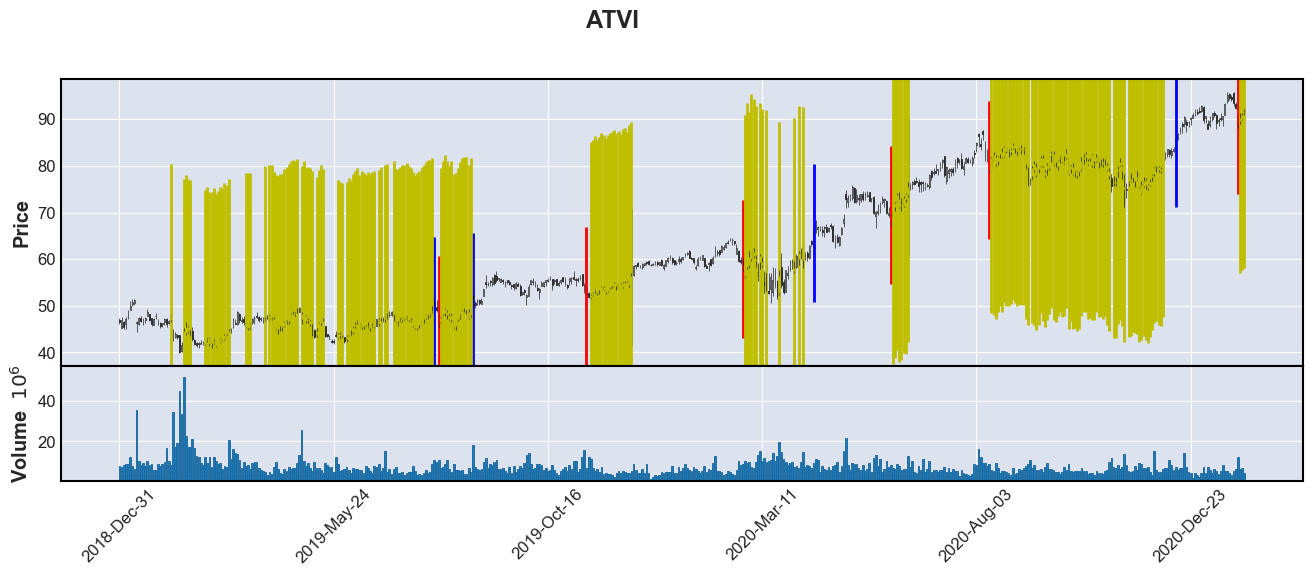

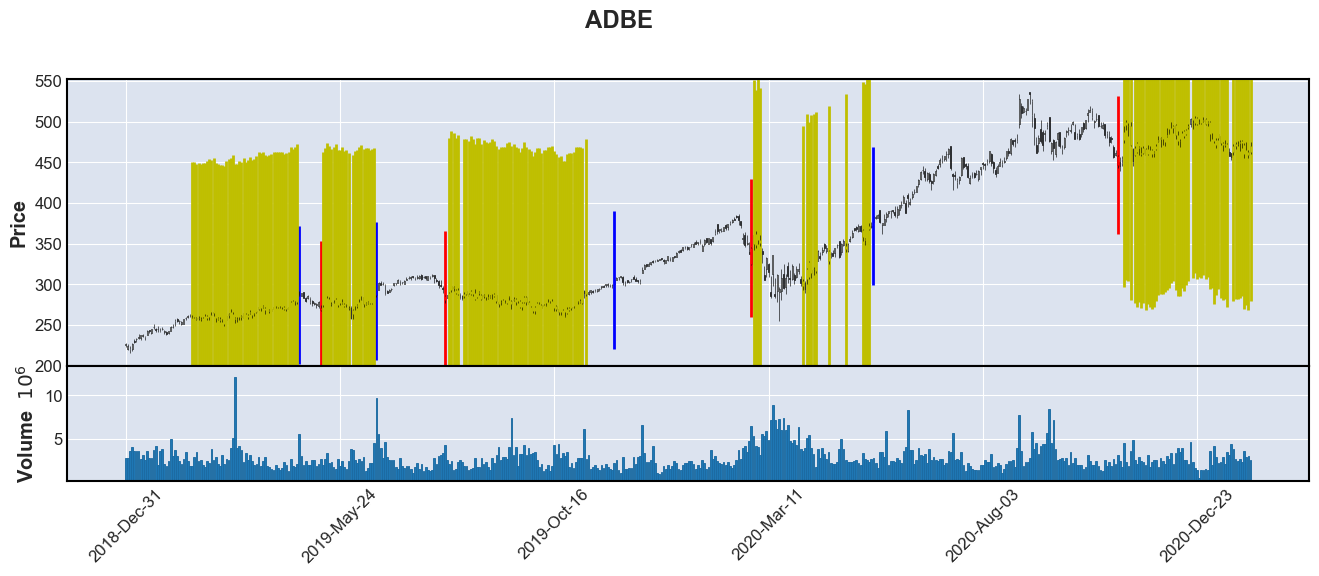

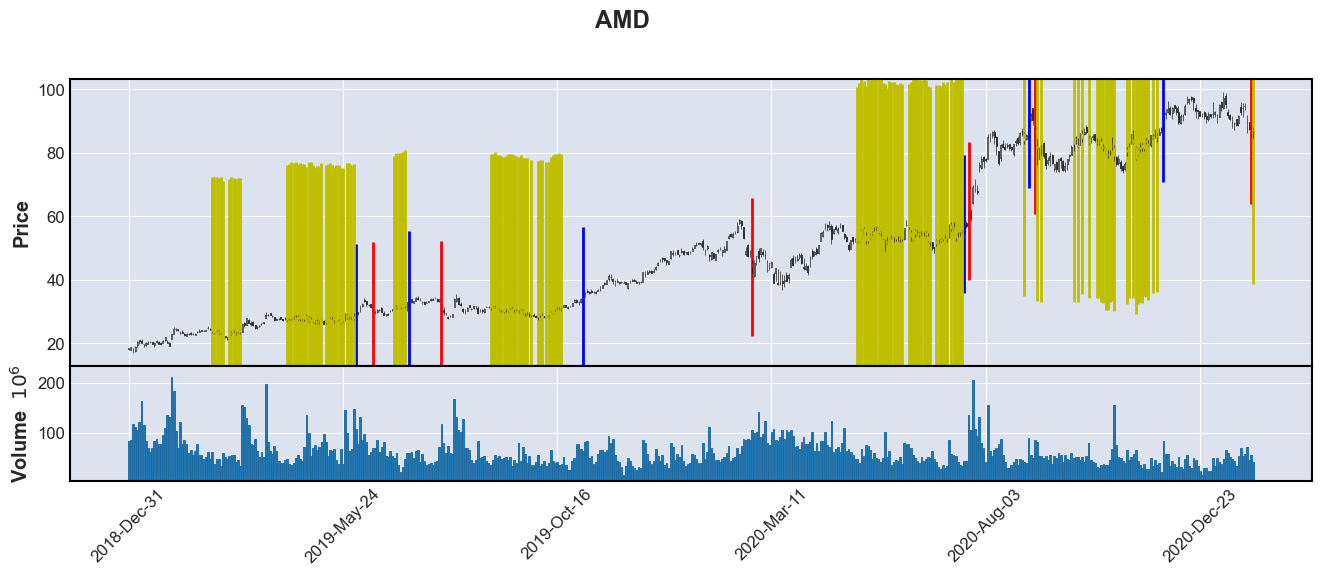

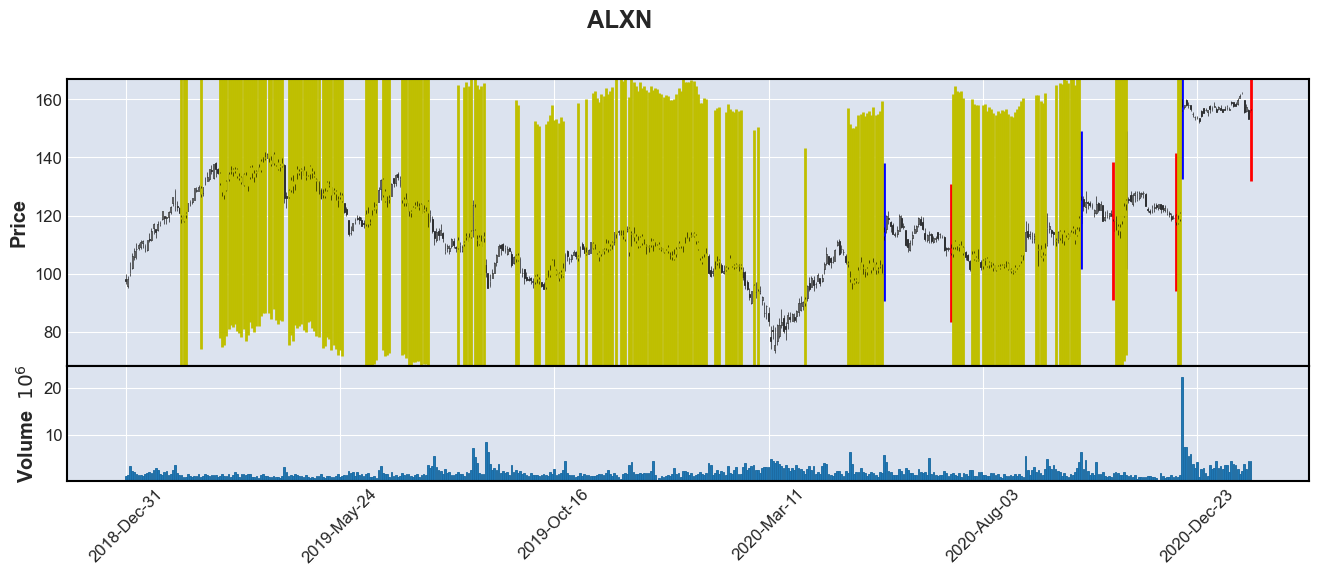

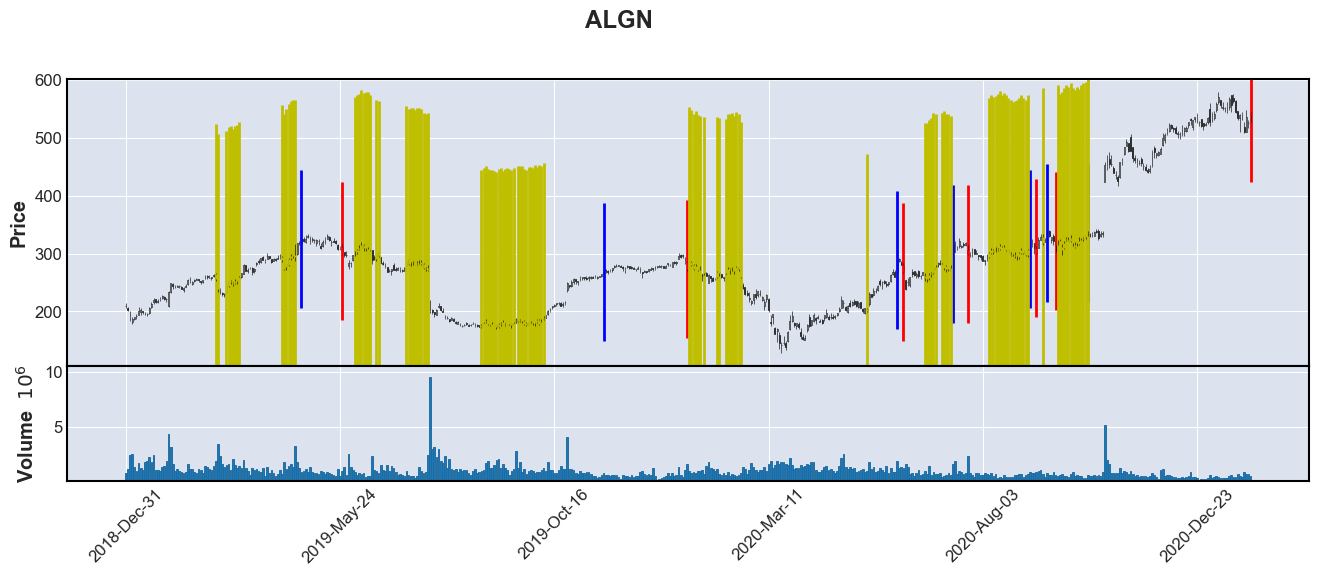

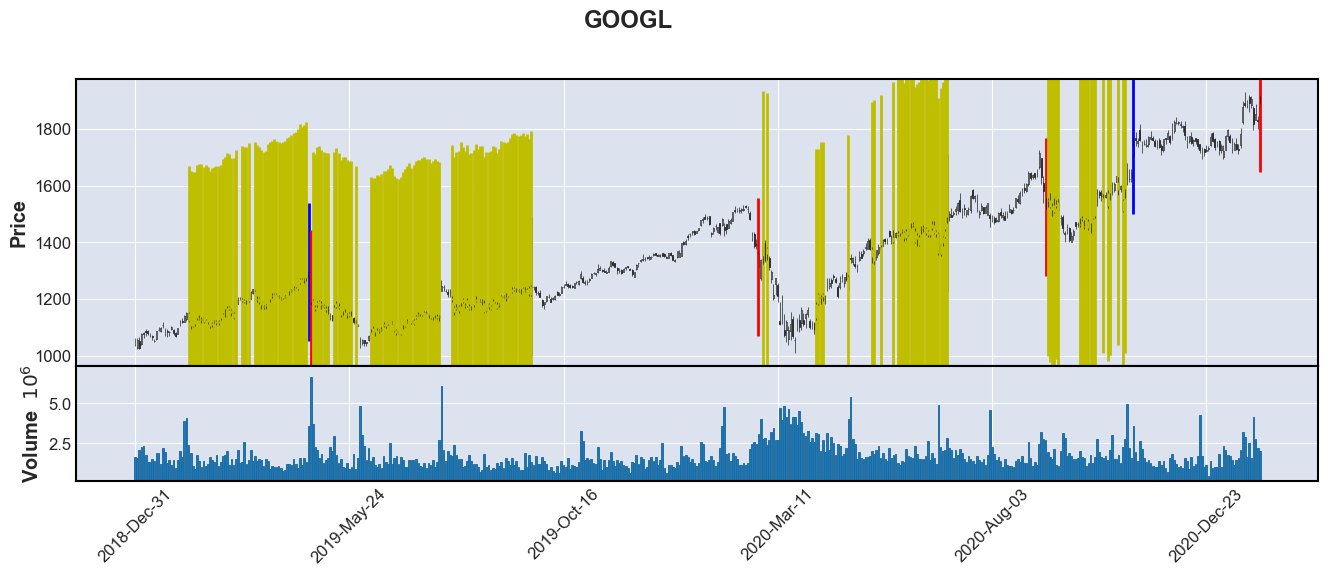

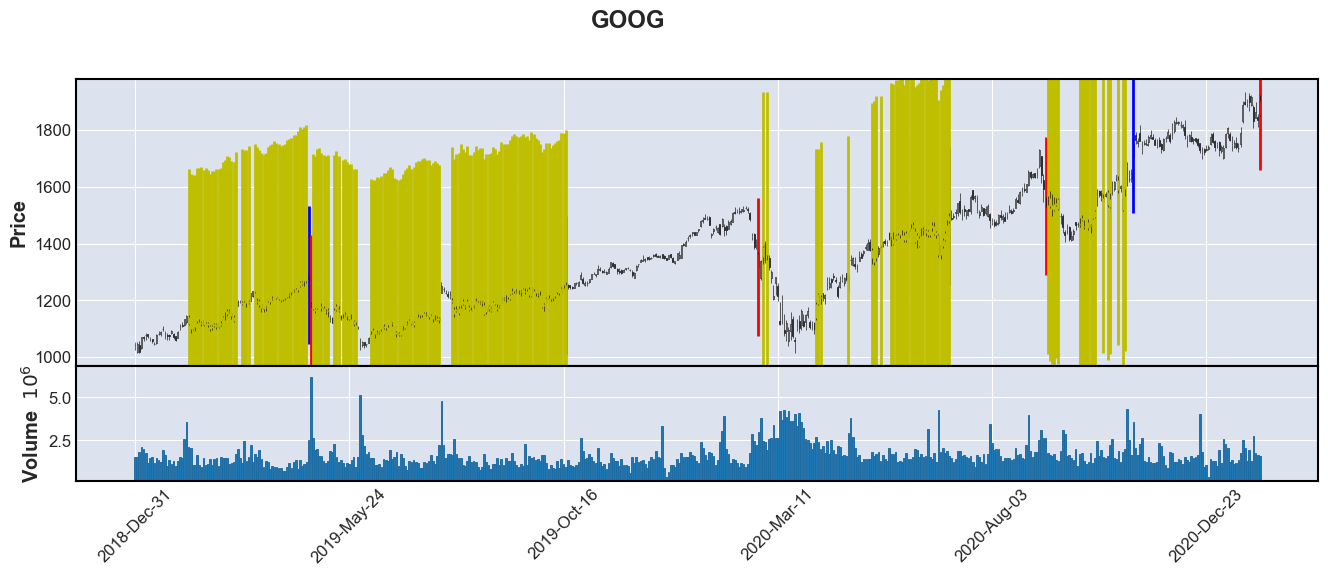

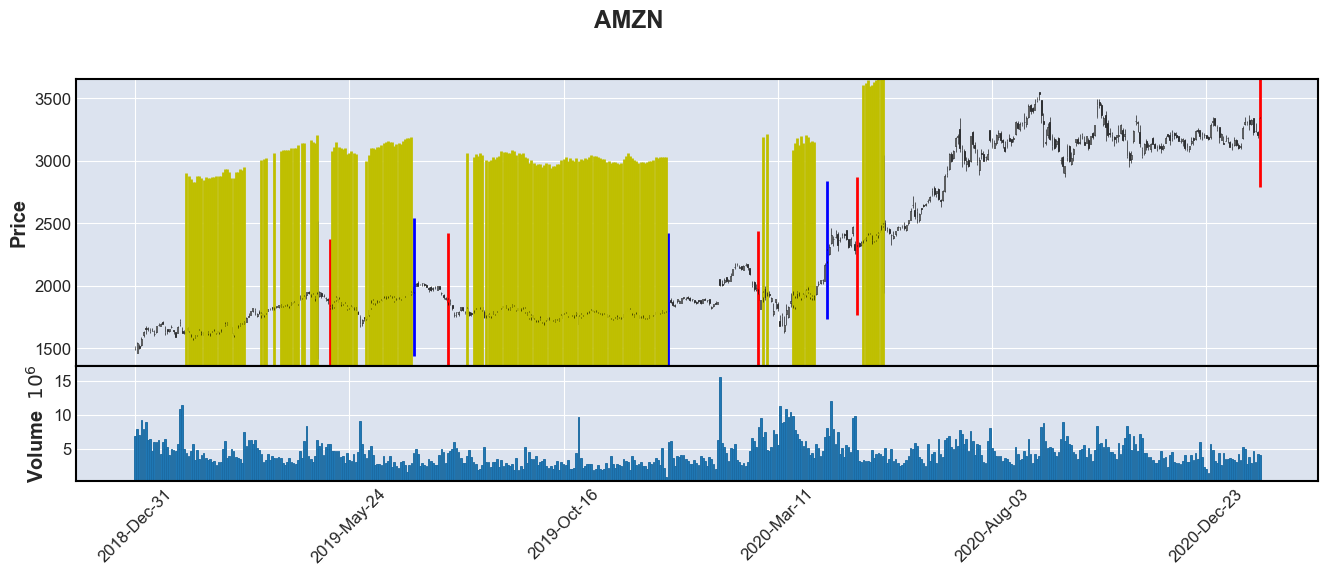

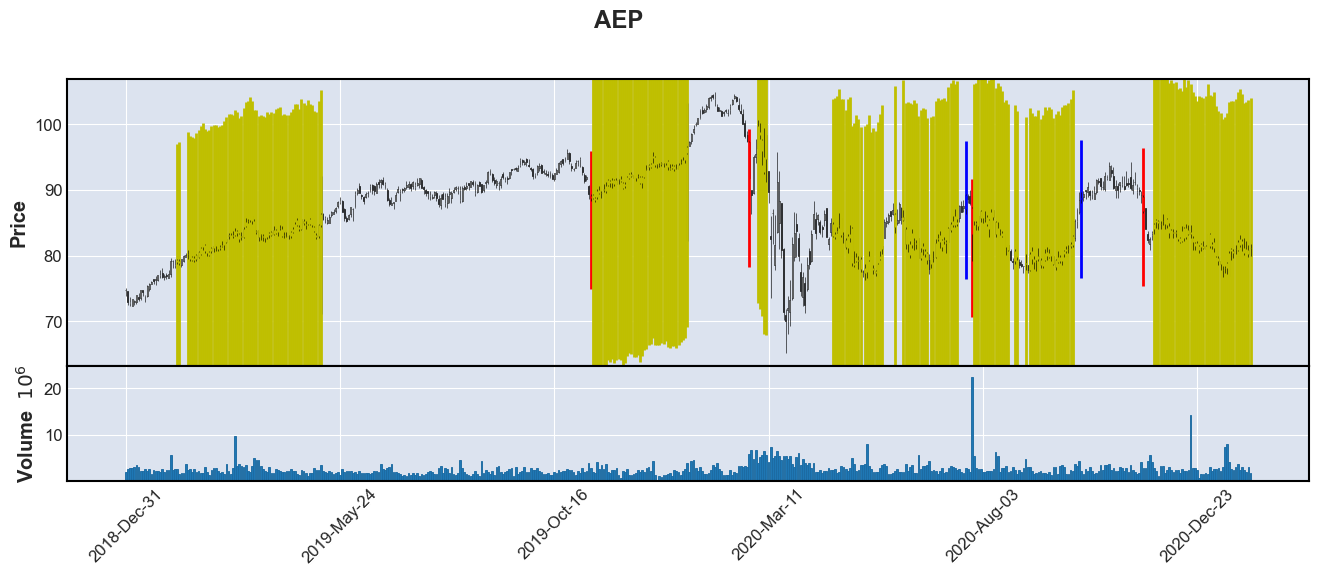

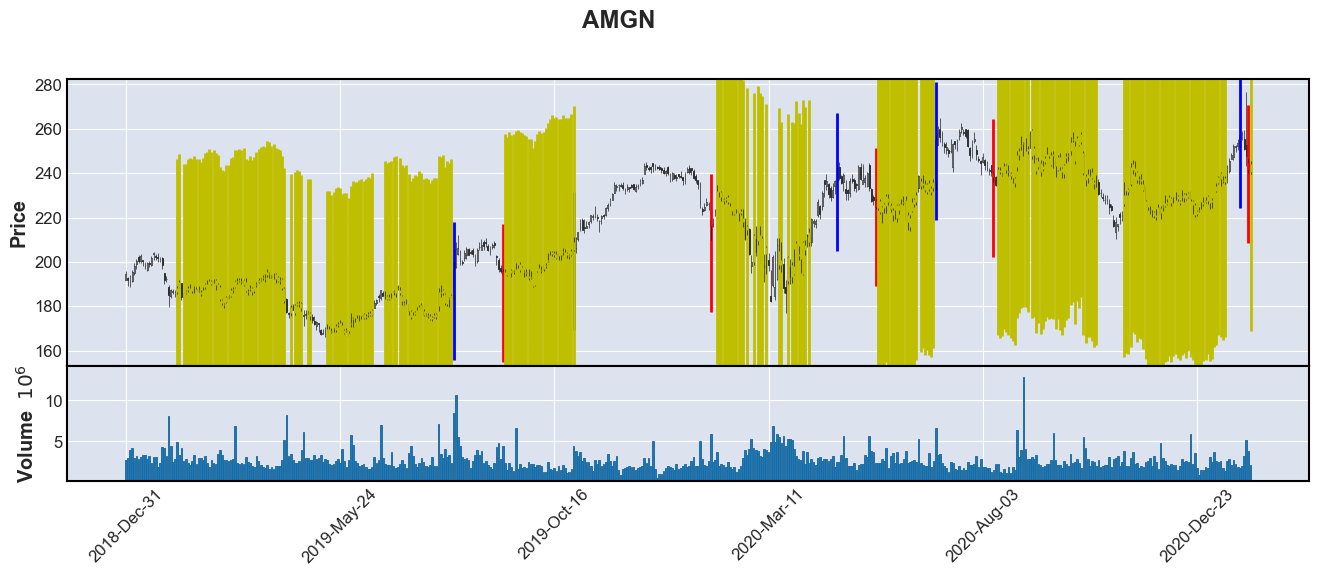

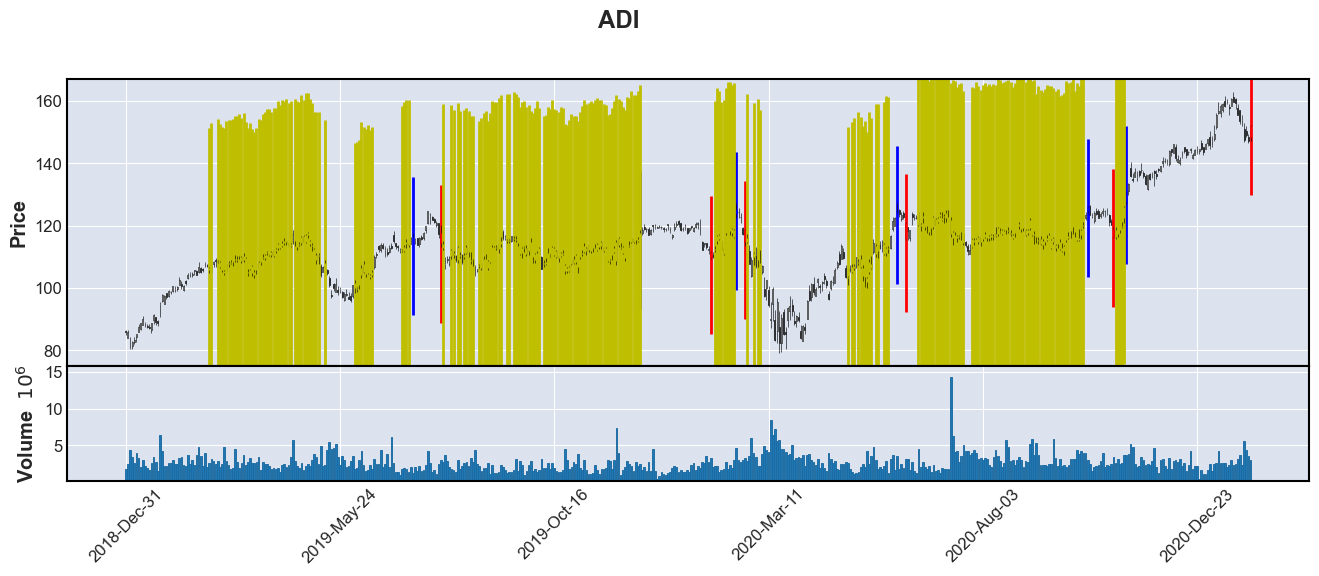

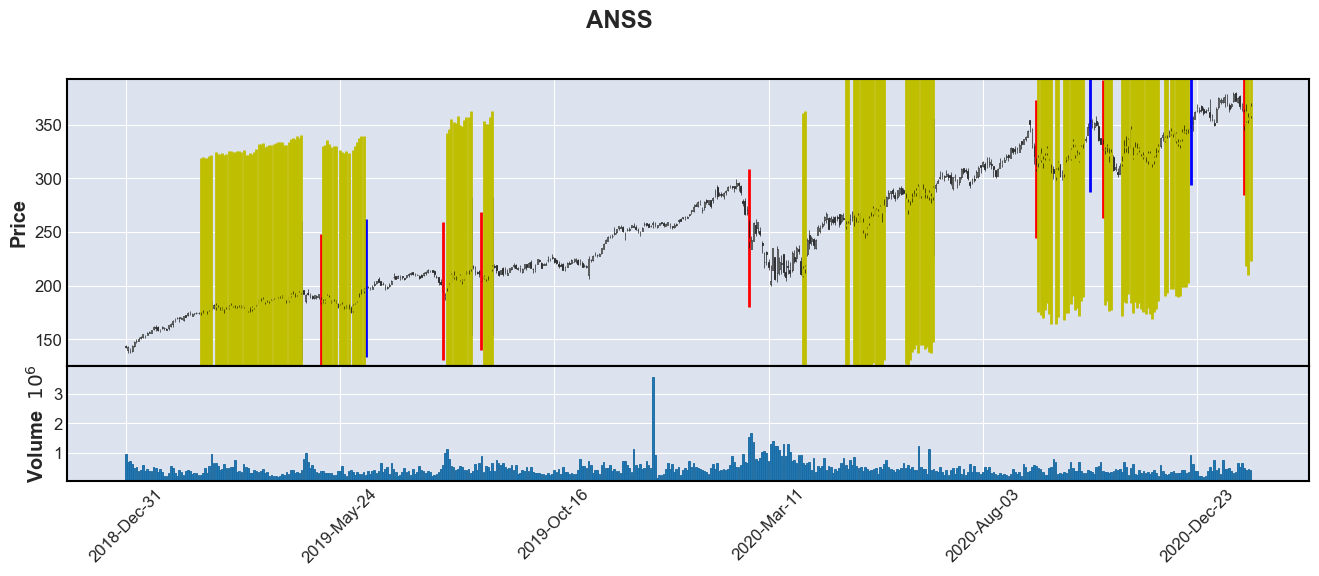

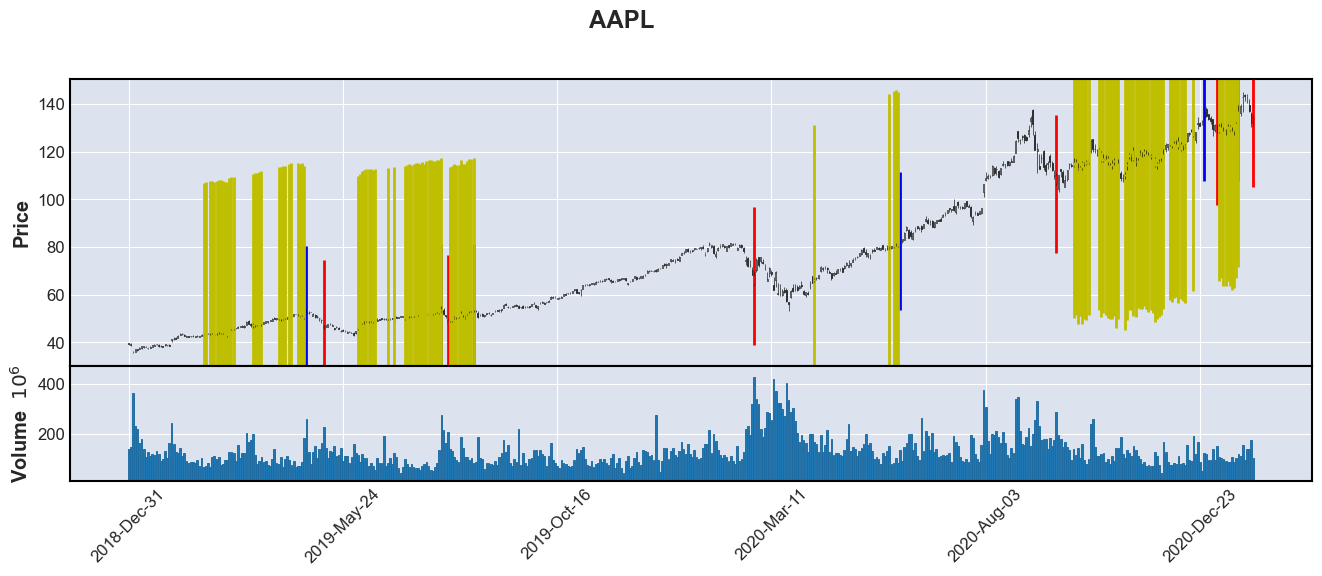

In [1]:
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import plotly.graph_objects as go
from plotly import tools
'''
戦略
ボラティリティー低下でシグナルを出す
上放れした時点で買い
ストップは順次あげていく
山田が修正している
'''

#install symbols nasdaq100の銘柄コード
df = pd.read_csv('../symbols/nasdaq100.csv')

# sign = ['ANSYS','ANSS']
signs = []
cnt = 0
for symbol in df['symbol']:
    cnt += 1
    if cnt == 15:
        break
    signs.append(symbol)
    

# sign = ['6976.T','4477.T','6036.T']
    

totalresult = []
start = '2019-01-01'
end = '2021-02-02'
    
'''
signは銘柄.銘柄ごとにfor分を回している.
'''

for sign in signs:
    stock_code = sign 
    df = yf.download(stock_code, start, end, interval='1d') 
    
    # dfが空の場合はスルー、結果は空の結果を格納
    if df.empty:
        print('{} is empty'.format(stock_code))
        results = []
        resultNum = 7 # 結果のカラム数
        for num in range(resultNum):
            results.append(np.nan)
        totalresult.append(results)
        continue;
    
    print(i)
    term=81
    # chek the highest price in the past {term} times
    df['Highest'+str(term)] = df.iloc[:, 4].rolling(window=term).max()
    print(df.head())
    
        
    
    # calculation SMA
    short_sma = 25
    long_sma = 50
    verylong_sma = 250
    #'term'日間の移動平均線
    df['SMA'+str(short_sma)] = df['Adj Close'].rolling(window=short_sma).mean()
    df['SMA'+str(long_sma)] = df['Adj Close'].rolling(window=long_sma).mean()
    df['SMA'+str(verylong_sma)] = df['Adj Close'].rolling(window=verylong_sma).mean()
      
    #slope of the sma SMAの傾き
    def diff(x):
        return x[-1] - x[0]
    trend_term = 2
    df['SMA Trend'] = df['SMA'+str(short_sma)].rolling(window=trend_term).apply(diff)
    
    # caluculation ATR
    h, l, c_prev = df['High'], df['Low'], pd.Series(df['Close']).shift(1)
    tr = np.max([h - l, (c_prev - h).abs(), (c_prev - l).abs()], axis=0)
    atr = pd.Series(tr).rolling(14).mean().bfill().values
    
    # caluculation range
    df['mean'+str(14)] = df.iloc[:, 4].rolling(window=14).mean()
    df['Highest'+str(14)] = df.iloc[:, 4].rolling(window=14).max()
    df['Lowest'+str(14)] = df.iloc[:, 4].rolling(window=14).min()
    df['range'+str(14)] = 100 * (df['Highest'+str(14)] - df['Lowest'+str(14)] )/ df['mean'+str(14)]
    
     # 損切り率
    stopLoss = 0.94
 
    
    #買い日と売り日とシグナルが出た日
    buy_days = []
    sell_days = []
    signal_days = []
    
    #holding period list 保有日数のリストで平均保有日数を出したい
    holding_period_list = []


    #calucurate Bband
    df['MA'] = df['Adj Close'].rolling(window=20).mean()
    df['STD'] = df['Adj Close'].rolling(window=20).std()
    df['Upper'] = df['MA'] + (df['STD'] * 2)
    df['Lower'] = df['MA'] - (df['STD'] * 2)
    
    #daviation_rate 移動平均線乖離率
    df['daviation_rate'] = 100 * (df['Adj Close'] - df['SMA'+str(short_sma)]) / df['SMA'+str(short_sma)]

    #Standard deviation normalization 正規化してみた
    df['Standard_deviation_normalization'] = 100 * 2 * df['STD'] / df['SMA'+str(short_sma)]
   
    buy_position = False
    isSignal = False
    percentChange = []
    
    #main loop---------------------------------------------------------------------------------------
    for i in range(1, len(df)):
        close = df['Adj Close'][i]
        STD = df['STD'][i]
        high_price = df['High'][i]
        low_price = df['Low'][i]
        open_price = df['Open'][i]
        sma = df['SMA'+str(short_sma)][i]
        SDN = df['Standard_deviation_normalization'][i]
        daviation_rate = df['daviation_rate'][i]
        Highest = df['Highest'+str(term)][i-1] #過去term日間の最高値
        

        # シグナルが出た日を示している
        if np.isnan(df['MA'][i]) == False:
            if buy_position == False and SDN < 10 and -5 < daviation_rate < 5 :
#                 print('low volatility')
                isSignal = True
                signalday = pd.to_datetime(df.index[i])
                signal_days.append(signalday)
                print(signalday)
            
        if isSignal == True and (pd.to_datetime(i) - signalday).days < 7 and close > Highest and buy_position == False:
            buy_position = True
            buyday = pd.to_datetime(df.index[i])
            buy_days.append(buyday)
            buy_price = close
            buy_stopLine = close * stopLoss
            buypoint = i
            current_stop_level = 0
            isSignal = False
            print('buy in {} at {}'.format(buyday,buy_price))
           
        
        #adjustment stopline
        if buy_position == True and close > buy_price * 1.05 and current_stop_level == 0:
            buy_stopLine = buy_price
            current_stop_level = 1
            print('up stopline1 in {} at {}'.format(df.index[i],buy_stopLine))
            
        if buy_position == True and close > buy_price * 1.1 and current_stop_level == 1:
            buy_stopLine = buy_price * 1.05
            current_stop_level = 2
            print('up stopline2 in {} at {}'.format(df.index[i],buy_stopLine))
            
        if buy_position == True and close > buy_price * 1.2 and current_stop_level == 2:
            buy_stopLine = buy_price * 1.1
            current_stop_level = 3
            print('up stopline3 in {} at {}'.format(df.index[i],buy_stopLine))
            
        if buy_position == True and close > buy_price * 1.3 and current_stop_level == 3:
            buy_stopLine = close * 0.85
            current_stop_level = 4
            print('up stopline4 in {} at {}'.format(df.index[i],buy_stopLine))
            
        if buy_position == True and close > buy_price * 1.5 and current_stop_level == 4:
            buy_stopLine = close * 0.8
            current_stop_level = 5  
            print('up stopline5 in {} at {}'.format(df.index[i],buy_stopLine))      
            
        if buy_position == True and close > Highest and current_stop_level == 5:
            buy_stopLine = close * 0.8
            current_stop_level = 5  
            print('up stopline6 in {} at {}'.format(df.index[i],buy_stopLine))
            
            
            
        # 損切り or Profit taking
        # 終値始値が損切りラインを下回ったら売る。
        if buy_position == True and open_price < buy_stopLine and i != buypoint:
            buy_position = False 
            percent = (open_price/buy_price - 1) * 100
            percentChange.append(percent)
            sellday = pd.to_datetime(df.index[i])
            sell_days.append(sellday)
            holding_period = sellday - buyday
            print('sell in {} at {} | profit_one is {}'.format(sellday,open_price,percent))
            
        elif buy_position == True and close < buy_stopLine and i != buypoint:
            buy_position = False 
            percent = (buy_stopLine/buy_price - 1) * 100
            percentChange.append(percent)
            sellday = pd.to_datetime(df.index[i])
            sell_days.append(sellday)
            holding_period = sellday - buyday
            holding_period_list.append(holding_period.days)
            print('sell in {} at {} | profit_two is {}'.format(sellday,buy_stopLine,percent))

        #  最終日にまだ持ってたら利確する
        if i == (len(df)-1) and buy_position == True:
            buy_position = False
            percent = (close / buy_price - 1) * 100
            percentChange.append(percent)
            sellday = pd.to_datetime(df.index[i])
            sell_days.append(sellday)
            holding_period = sellday - buyday
            holding_period_list.append(holding_period.days)
            print('Date:'+str(i),'Last Day Buy at the price {}'.format(close))

       
    # statistic
#     ------------------------------------------
    gains = 0
    losses = 0
    numlosses = 0
    numgains = 0
    total_return = 1


    for i in percentChange:
        if i > 0:
            numgains += 1
            gains += i
        else:
            numlosses += 1
            losses += i
        total_return = total_return * ((i / 100) + 1)
        
        
    total_return = round((total_return - 1)*100, 2)
    if numgains > 0:
        ave_gain = gains / numgains
#         max_return = max(percentChange)
    else:
        ave_gain = 0
        max_return = 'unknown'
    
    if numlosses > 0:
        ave_loss = losses / numlosses
#         max_loss = min(percentChange)
        risk_reward_retio = - ave_gain / ave_loss
    else:
        ave_loss = 0
        max_loss = 'unknown'
        risk_reward_retio = 'inf'
    
    if numgains > 0 or numlosses > 0:
        batting_retio = numgains / (numgains + numlosses)
    else:
        batting_retio = 0
    
    trades = numgains + numlosses
    ave_total = ave_gain * batting_retio + ave_loss * (1 - batting_retio)
    
    #average holding period
    if len(holding_period_list) != 0:   
        average_holding_period = sum(holding_period_list)/len(holding_period_list)
    

    results = [numgains+numlosses, round(total_return,2), round(ave_gain,2), round(ave_loss,2)
               ,batting_retio ,ave_total ,average_holding_period]
    
    if not results is None:
         totalresult.append(results)
            
    

    #plot figure --------------------------------------------------------- 
    buy_plot = []
    sell_plot = []
    signal_plot = []
    for i in df.index:
        if i in buy_days:
            buy_plot.append(df['Adj Close'][i])
        else:
            buy_plot.append(np.nan)
        if i in sell_days:
            sell_plot.append(df['Adj Close'][i])
        else:
            sell_plot.append(np.nan)
        if i in signal_days:
            signal_plot.append(df['Adj Close'][i])
        else:
            signal_plot.append(np.nan)
    print(len(signal_days),len(signal_plot))
    adp = [
        mpf.make_addplot(buy_plot,type='scatter',color='b',marker='|',markersize=10000),
        mpf.make_addplot(sell_plot,type='scatter',color='r',marker='|',markersize=10000),
        mpf.make_addplot(signal_plot,type='scatter', color='y', marker='|', markersize=50000)
    ]
    fig, ax = mpf.plot(df,type='candle',figratio=(45,15),
                      addplot=adp, volume=True, title=str(stock_code), returnfig=True)
#     legend = ['Short_SMA(20)','Long_SMA(50)']
#     ax[0].legend(legend,fontsize=16)

#     signal_signals = []
#     for i in df.index:
#         if i in signal_days:
#             signal_signals.append(df['Adj Close'][i])
#         else:
#             signal_signals.append(np.nan)
#     signal_df = pd.DataFrame({'signal_signals':signal_signals})

    
    
    
#     x = np.arange(len(df.index)) #x軸を0からデータの個数まで1ずつ増える数列
#     labels = df.index #x軸ラベルを日付にする

    
#     data = go.Candlestick(x = df.index, open=df['Open'],high=df['High'],low=df['Low'],close=df['Close'],
#                          yaxis = 'y1', name  = stock_code)
#     sma_short = go.Scatter(x = df.index, y = df['SMA'+str(short_sma)], mode = 'lines',yaxis = 'y1')
#     sma_long = go.Scatter(x = df.index, y = df['SMA'+str(long_sma)], mode = 'lines',yaxis = 'y1')
#     sma_verylong = go.Scatter(x = df.index, y = df['SMA'+str(verylong_sma)], mode = 'lines',yaxis = 'y1')
#     upper_Bband = go.Scatter(x = df.index, y = df['Upper'], mode = 'lines',yaxis = 'y1')
#     lower_Bband = go.Scatter(x = df.index, y = df['Lower'], mode = 'lines',yaxis = 'y1')
#     Standard_deviation_normalization = go.Scatter(x = df.index, y = df['Standard_deviation_normalization'], 
#                                                   mode = 'lines',yaxis = 'y2')
#     STD = go.Scatter(x = df.index, y = df['STD'], mode = 'lines',yaxis = 'y3')
#     #signal = go.Scatter(x = df.index, y = signal_df , mode = 'scatter',yaxis = 'y1')
     
        
    
        
    
#     # レイアウトの指定
#     layout = go.Layout(xaxis = dict(title = 'date', type='date', dtick = 'M1'),
#                        yaxis = dict(title = 'value') ,
#                        yaxis2 = dict(title = 'STD'))  
#     # dtick: 'M1'で１ヶ月ごとにラベル表示 
    
    
    
#     fig = tools.make_subplots(rows=3, cols=1,
#                               subplot_titles=(stock_code,"STD"))
    
#     fig.append_trace(data, 1, 1)
#     fig.append_trace(sma_short, 1, 1)
#     fig.append_trace(sma_long, 1, 1)
#     fig.append_trace(sma_long, 1, 1)
#     fig.append_trace(Standard_deviation_normalization, 2, 1)
#     fig.append_trace(STD, 3, 1)
    
    
#     fig['layout'].update(height=1300, width=1200)

#     fig.show()
    
#      = go.Scatter(x = df.index, y = df['SMA'+str(short_sma)], mode = 'lines')

    
# #     make figure
# #     df['70'] = 70
# #     df['30'] = 30
# #     df['50'] = 50
# #     df['0'] = 0
    
# #     signal_signals = []
# #     for i in df.index:
# #         if i in signal_days:
# #             signal_signals.append(df['Adj Close'][i])
# #         else:
# #             signal_signals.append(np.nan)
            
            
# #     if np.all(signal_signals) == True:
# #         apds = [
# #         mpl.make_addplot( df['Volume'] , panel=3, ylabel='Volume'),
# #         mpl.make_addplot(df['Upper'], type='line' ,color="r"),
# #         mpl.make_addplot(df['Lower'], type='line',color="r"),
# #         mpl.make_addplot(df['Standard_deviation_normalization'], panel=1, type='line', ylabel='STD'),
# #         mpl.make_addplot( df[['daviation_rate','0']] , panel=2, type='line', ylabel='daviation_rate'),
# #         ]
   
# # # mpl.make_addplot(signal_signals, type='scatter', markersize=10000, marker='|', color="b"),
# #         fig = mpl.plot(df, type='candle',figsize=(30, 15), style='yahoo',mav=(short_sma, long_sma, verylong_sma)
# #                        , addplot=apds, title=str(stock_code))



columns = ['trades', 'Total return', 'Average Gain', 'Average Loss', '勝率' ,'Average gain and profit','average holding period']
df = pd.DataFrame(totalresult, columns=columns, index = sign)
df.to_csv('./volatility_result.csv')

print(df)
print(1)